## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/analysisFunctions.py

## Download speech data

In [4]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [5]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835


In [6]:
trainDF.head()

,files,labels,category
0,speechData/train/zero/f92e49f3_nohash_3.wav,17,zero
1,speechData/train/five/9a3f97f8_nohash_0.wav,20,five
2,speechData/train/three/6f9088d7_nohash_0.wav,14,three
3,speechData/train/five/f852895b_nohash_0.wav,20,five
4,speechData/train/tree/421ed23f_nohash_0.wav,15,tree


## Tensorflow 2.0

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [8]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


## Input pipeline

In [0]:
!pip install -q python_speech_features

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 30000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False
) 


## Models

In [11]:
from models import rnn_att_model

model_lstm = rnn_att_model()
model_gru = rnn_att_model(rnn = 'GRU')

model_lstm.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])
model_lstm.summary()

model_gru.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])
model_gru.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 99, 40)]     0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 99, 40, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 99, 40, 1)    4           reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 99, 40, 30)   300         batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [10]:
EPOCHS = 25

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

history_lstm = model_lstm.fit(train_data.repeat(), 
               steps_per_epoch=train_steps,
               validation_data=val_data.repeat(),
               validation_steps=val_steps,
               epochs=EPOCHS,
               callbacks=[earlyStopping, reduceLR])

history_gru = model_gru.fit(train_data.repeat(), 
               steps_per_epoch=train_steps,
               validation_data=val_data.repeat(),
               validation_steps=val_steps,
               epochs=EPOCHS,
               callbacks=[earlyStopping, reduceLR])

W0712 19:03:08.457056 140309521524480 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0712 19:03:08.458785 140309513131776 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0712 19:03:08.460170 140309513131776 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0712 19:03:08.461504 140309513131776 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0712 19:03:08.459117 140309521524480 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


Epoch 1/25


W0712 19:05:20.692289 140312786642816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


937/937 [==============================] - 208s 222ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.5179 - val_sparse_categorical_accuracy: 0.8449
Epoch 2/25
937/937 [==============================] - 37s 39ms/step - loss: 0.4077 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.3697 - val_sparse_categorical_accuracy: 0.8983
Epoch 3/25
937/937 [==============================] - 35s 37ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.3685 - val_sparse_categorical_accuracy: 0.8903
Epoch 4/25
937/937 [==============================] - 35s 38ms/step - loss: 0.2551 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.3046 - val_sparse_categorical_accuracy: 0.9144
Epoch 5/25
937/937 [==============================] - 36s 38ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9335 - val_loss: 0.3398 - val_sparse_categorical_accuracy: 0.9062
Epoch 6/25
937/937 [==============================] - 36s 38ms/step - loss: 0.1913 - sparse_categor

## Save model and trainign history  to drive

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/rnnModel

mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/rnnModel’: File exists


In [13]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/rnnModel/"

## Save model 
model_lstm_json = model_lstm.to_json()
with open(GDRIVE_PATH + "model_lstm.json", "w") as file:
    file.write(model_lstm_json)
# serialize weights to HDF5
model_lstm.save_weights(GDRIVE_PATH + "model_lstm_weights.h5")
print("Saved lstm model to drive")

model_gru_json = model_gru.to_json()
with open(GDRIVE_PATH + "model_gru.json", "w") as file:
    file.write(model_gru_json)
# serialize weights to HDF5
model_gru.save_weights(GDRIVE_PATH + "model_gru_weights.h5")
print("Saved gru model to drive")

Saved lstm model to drive
Saved gru model to drive


In [14]:
import pickle
## Save history data
with open(GDRIVE_PATH + "lstm_train_results.pickle", "wb") as handle:
    pickle.dump(history_lstm.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved lstm training history to drive")

with open(GDRIVE_PATH + "gru_train_results.pickle", "wb") as handle:
    pickle.dump(history_gru.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved gru training history to drive")

Saved lstm training history to drive
Saved gru training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "lstm_train_results.pickle", 'rb') as handle:
    lstm_hist = pickle.load(handle)
    
with open(GDRIVE_PATH + "gru_train_results.pickle", 'rb') as handle:
    gru_hist = pickle.load(handle)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

lstm_acc = lstm_hist['sparse_categorical_accuracy']
lstm_val_acc = lstm_hist['val_sparse_categorical_accuracy']

lstm_loss = lstm_hist['loss']
lstm_val_loss = lstm_hist['val_loss']

gru_acc = gru_hist['sparse_categorical_accuracy']
gru_val_acc = gru_hist['val_sparse_categorical_accuracy']

gru_loss = gru_hist['loss']
gru_val_loss = gru_hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(16,8))

ax1[0].plot(lstm_loss, label='lstm train')
ax1[0].plot(lstm_val_loss, label='lstm validation')
ax1[0].set_title('Model loss')
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

ax1[1].plot(gru_loss, label='gru train')
ax1[1].plot(gru_val_loss, label='gru validation')
ax1[1].set_title('Model loss')
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Loss')
ax1[1].legend()

ax2[0].plot(lstm_acc, label='lstm train')
ax2[0].plot(lstm_val_acc, label='lstm validation')
ax2[0].set_title('Model accuracy')
ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('Accuracy')
ax2[0].legend()

ax2[1].plot(gru_acc, label='gru train')
ax2[1].plot(gru_val_acc, label='gru validation')
ax2[1].set_title('Model accuracy')
ax2[1].set_xlabel('Epoch')
ax2[1].set_ylabel('Accuracy')
ax2[1].legend()

plt.tight_layout()
fig.show()

NameError: ignored

### Predict



In [17]:
lstm_out = model_lstm.predict(test_data, verbose=1)
gru_out = model_gru.predict(test_data, verbose=1)

214/214 [==============================] - 4s 20ms/step


In [30]:
import numpy as np
lstm_y_pred = np.argmax(lstm_out, axis=1)
gru_y_pred = np.argmax(gru_out, axis=1)
y_true = testDF['labels'].tolist()

NameError: ignored

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('LSTM Accuracy: {:.4f}'.format(accuracy_score(lstm_y_pred, y_true)))
print('GRU Accuracy: {:.4f}'.format(accuracy_score(gru_y_pred, y_true)))

lstm_cm = confusion_matrix(lstm_y_pred, y_true)
gru_cm = confusion_matrix(gru_y_pred, y_true)

LSTM Accuracy: 0.9434
GRU Accuracy: 0.9456


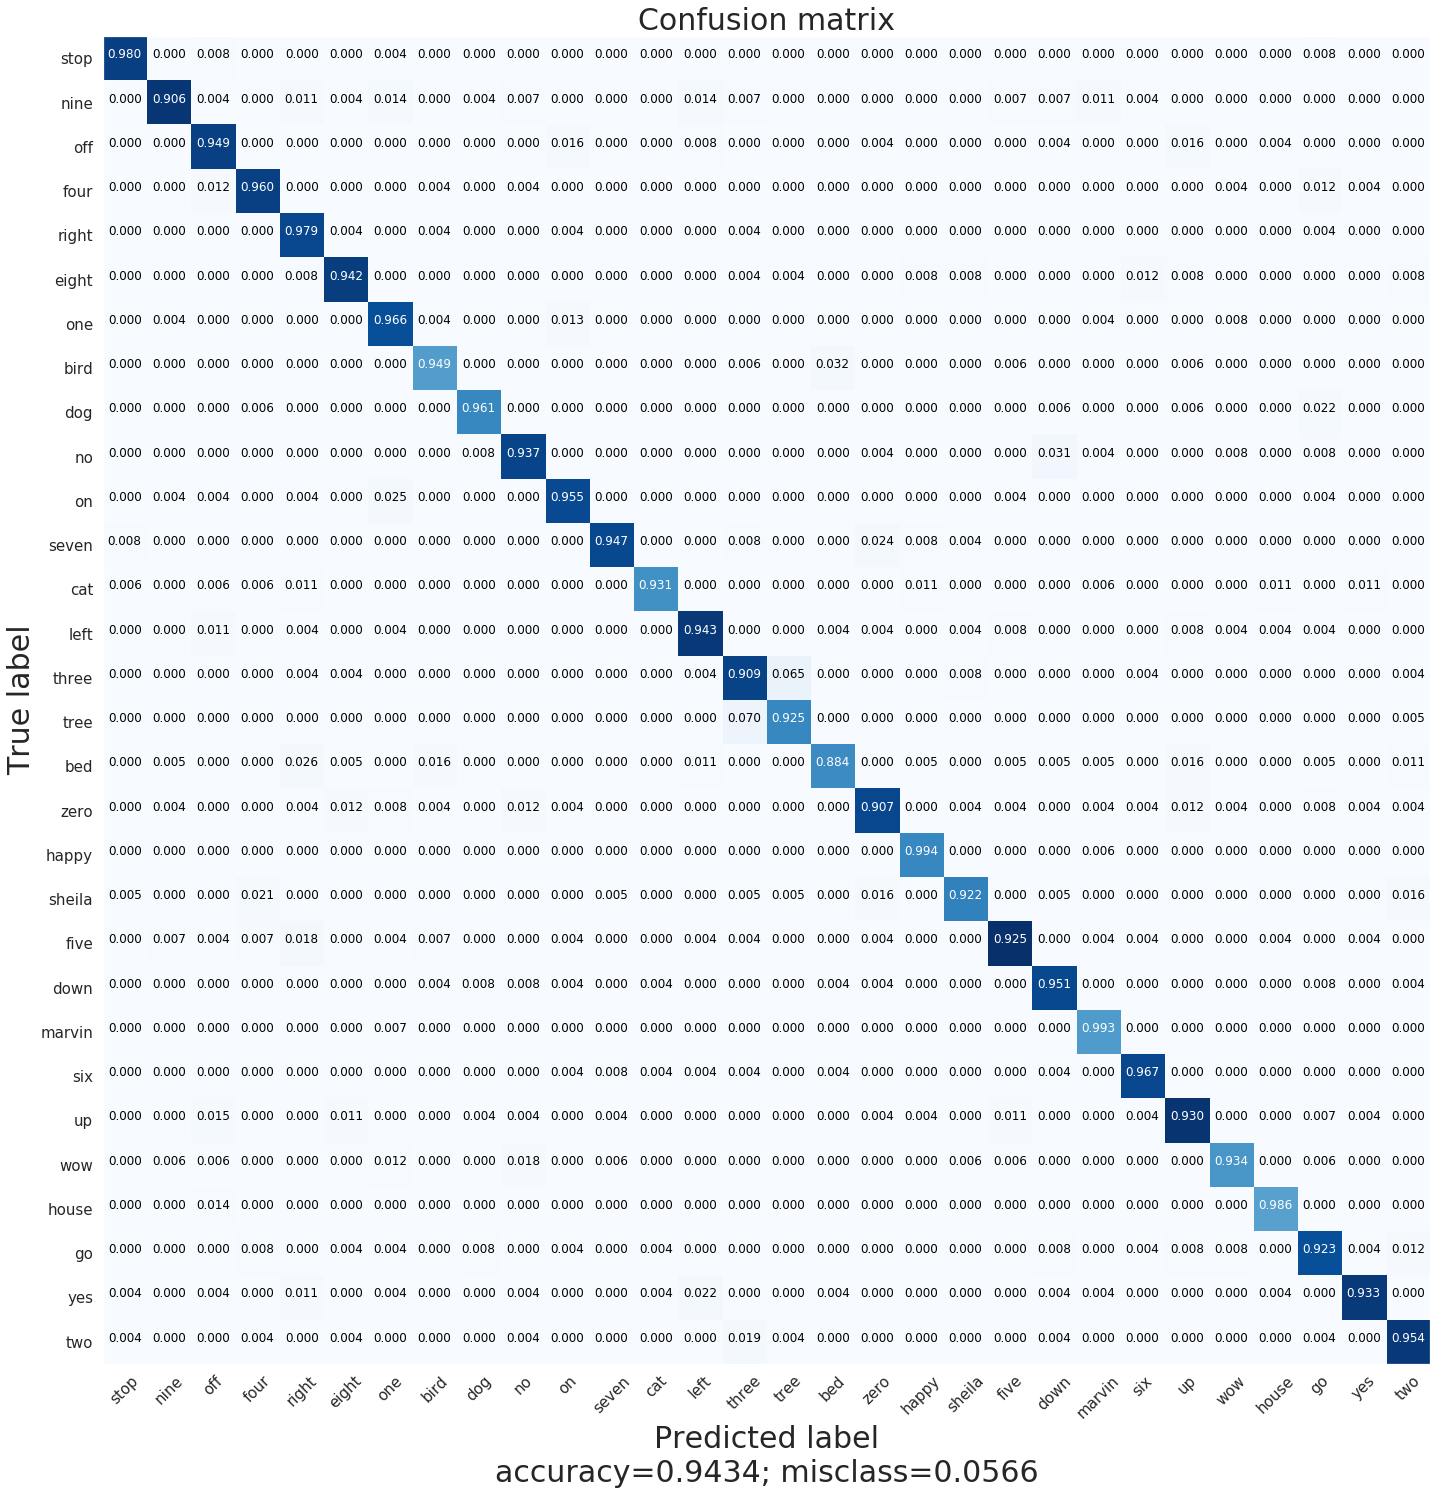

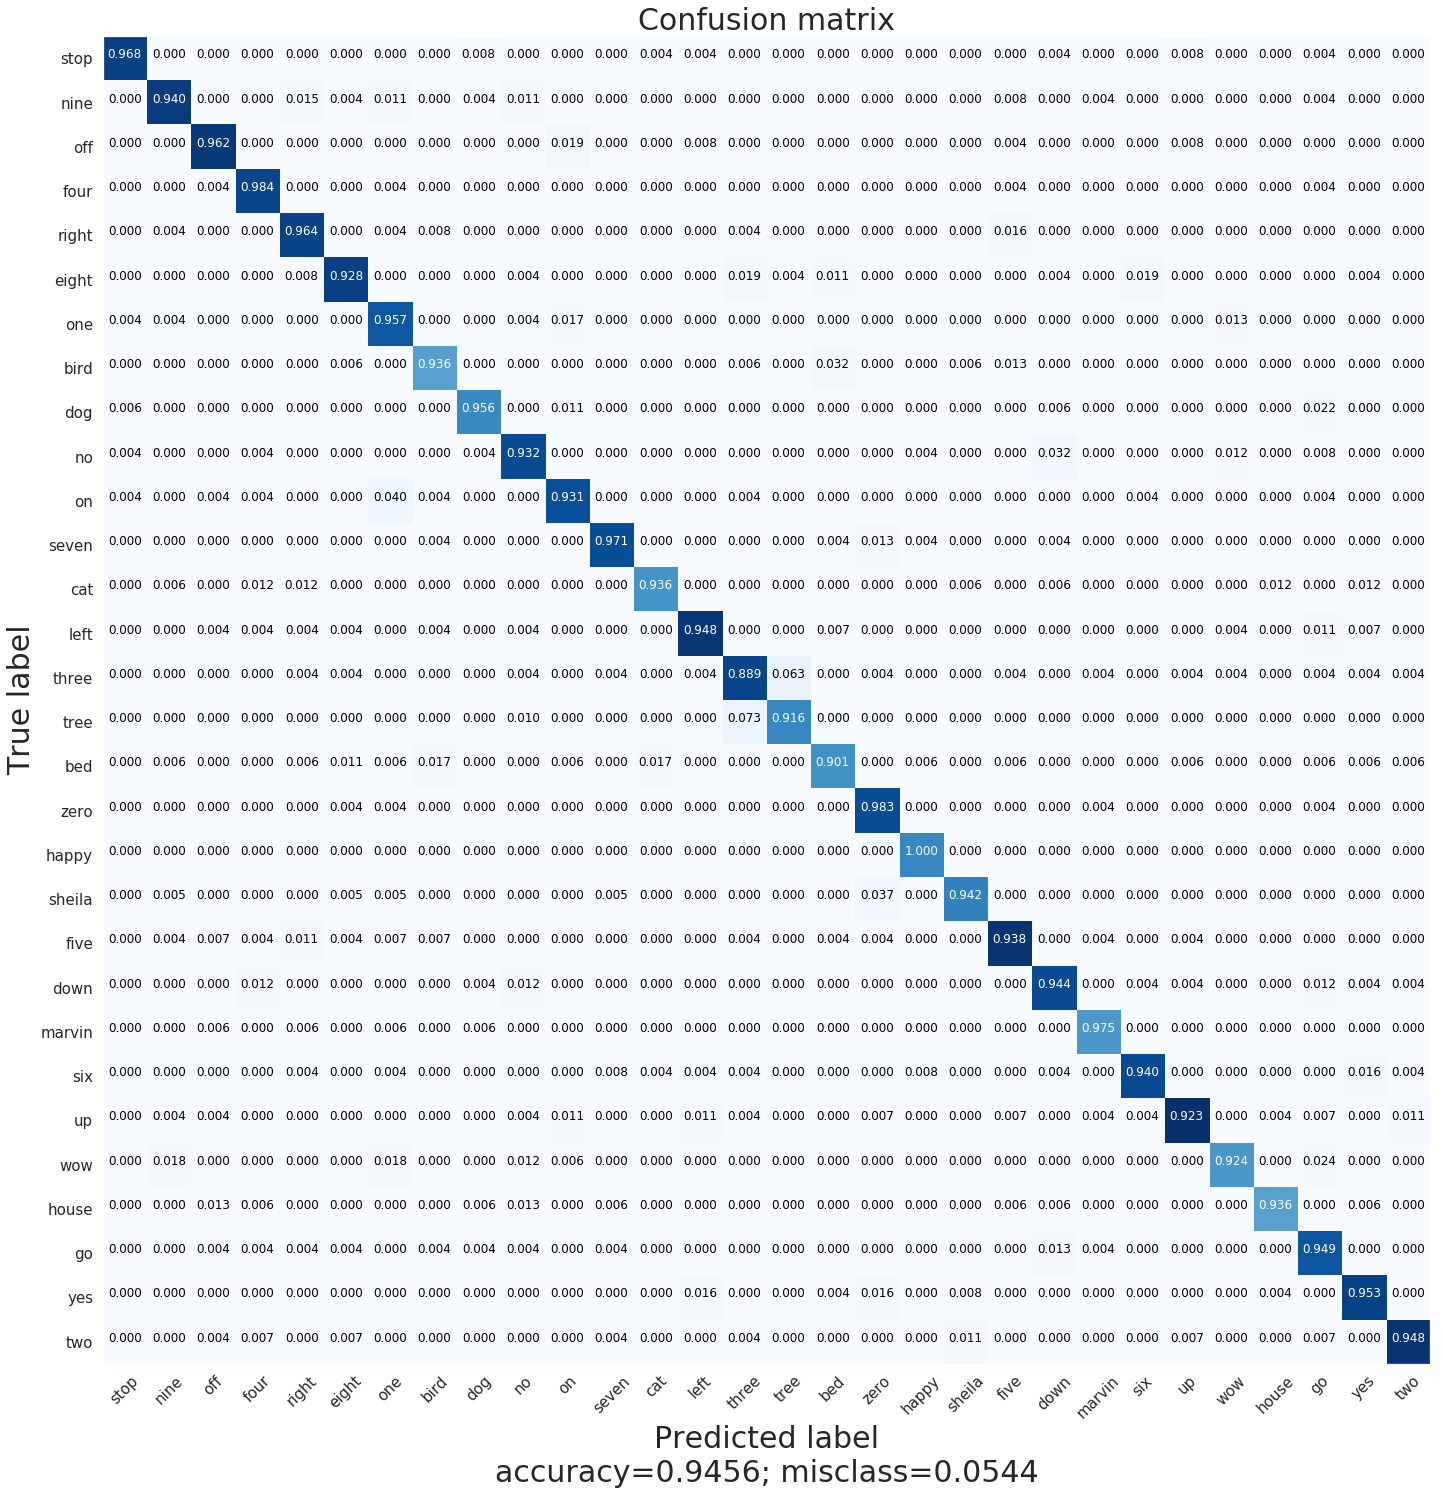

In [20]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(lstm_cm, target_names=list(inv_categories.values())[:-1], normalize=True)
plot_confusion_matrix(gru_cm, target_names=list(inv_categories.values())[:-1], normalize=True)

In [27]:
layer_out = tf.keras.Model(inputs=model_lstm.input, outputs=model_lstm.get_layer('Attention').output)
attention = layer_out.predict(test_data, verbose=1)

214/214 [==============================] - 4s 18ms/step
(6835, 99, 60)
[[ 0.09031006  0.220261   -0.42701057 ...  0.1965562   0.02004613
  -0.0099635 ]
 [ 0.09015886  0.22021401 -0.42680395 ...  0.1964598   0.02048848
  -0.00986561]
 [ 0.08999198  0.22003475 -0.42634663 ...  0.1963081   0.02085849
  -0.00975373]
 ...
 [ 0.08946793  0.21886364 -0.42371902 ...  0.19556978  0.02176238
  -0.00935321]
 [ 0.08952583  0.2187911  -0.4236228  ...  0.19561277  0.02171655
  -0.00936407]
 [ 0.0895584   0.21877101 -0.42360595 ...  0.19560294  0.02155842
  -0.0093869 ]]


(6835, 99)


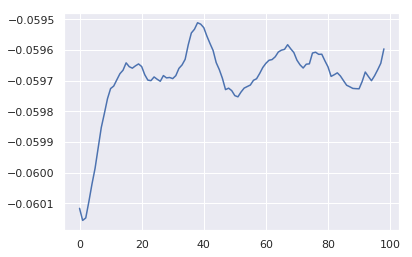

In [48]:
# plt.matshow(attention[0,:,:])
attention_avg = np.apply_along_axis(np.mean,2,attention)
print(attention_avg.shape)
plt.plot(attention_avg[2])
plt.show()